In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'beirveliolu'
os.environ['KAGGLE_KEY']      = 'de27b3bbfd5a53969fe0c2f6bf9d536b'


In [2]:
!kaggle datasets download -d shubhamgoel27/dermnet #download the dataset form Kaggle

Dataset URL: https://www.kaggle.com/datasets/shubhamgoel27/dermnet
License(s): Attribution-NonCommercial-NoDerivatives 4.0 International (CC BY-NC-ND 4.0)


In [3]:
!unzip dermnet.zip  -d dermnet

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keloids-8.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keloids-80.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keloids-9.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-100.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-101.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-102.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-103.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-104.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-105.jpg  
  inflating: dermnet/train/Seborrheic Keratoses and other Benign Tumors/keratoacanthoma-106.jpg  
  

In [4]:
!ls dermnet/train

'Acne and Rosacea Photos'
'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions'
'Atopic Dermatitis Photos'
'Bullous Disease Photos'
'Cellulitis Impetigo and other Bacterial Infections'
'Eczema Photos'
'Exanthems and Drug Eruptions'
'Hair Loss Photos Alopecia and other Hair Diseases'
'Herpes HPV and other STDs Photos'
'Light Diseases and Disorders of Pigmentation'
'Lupus and other Connective Tissue diseases'
'Melanoma Skin Cancer Nevi and Moles'
'Nail Fungus and other Nail Disease'
'Poison Ivy Photos and other Contact Dermatitis'
'Psoriasis pictures Lichen Planus and related diseases'
'Scabies Lyme Disease and other Infestations and Bites'
'Seborrheic Keratoses and other Benign Tumors'
'Systemic Disease'
'Tinea Ringworm Candidiasis and other Fungal Infections'
'Urticaria Hives'
'Vascular Tumors'
'Vasculitis Photos'
'Warts Molluscum and other Viral Infections'


In [5]:
!pip install fvcore=='0.1.dev200114'


  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.dev200114-py3-none-any.whl size=30350 sha256=847a7ebb6e9d1b61796e20e78cbd82ed3bc210c6c0f8b001ae51933ab8cdcde4
  Stored in directory: /root/.cache/pip/wheels/9a/65/84/33e079e2416b9d0771bfad81056f0f4b07a2ceea48b7ecf299
Successfully built fvcore


In [6]:
import os
import cv2
import time
import numpy as np
import pandas as pd
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.nn.functional as F

import itertools
import logging
from typing import Any, Dict, Iterable, List, Optional, Tuple, Type
import tqdm

from torch.utils.data import DataLoader, Dataset

import torchvision
import torchvision.transforms as T
import torchvision.models as models
from torchvision.utils import make_grid
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import fvcore
from fvcore.nn.precise_bn import update_bn_stats

import argparse
import sys
import datetime
import math
import json
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mp_image
from sklearn.metrics import confusion_matrix
import seaborn as sns

from PIL import Image
import torch.distributed as dist
import torch.backends.cudnn as cudnn
from torchvision import datasets, transforms
from torchvision import models as torchvision_models
torch.cuda.empty_cache()

DIR = "dermnet"
DIR_TRAIN = "dermnet/train/"
DIR_TEST = "dermnet/test/"

In [7]:
# Exploring Dataset

classes = os.listdir(DIR_TRAIN)
print("Total Classes: ",len(classes))

#Counting total train, valid & test images

train_count = 0
valid_count = 0
test_count = 0

classes_df = []
for _class in classes:
    class_dict = {}
    train_count += len(os.listdir(DIR_TRAIN + _class))
    test_count += len(os.listdir(DIR_TEST + _class))
    #print(f'Class {_class}: train amount {train_count}, test amount {test_count} ')
    class_dict.update({'Class': _class, 'Train': len(os.listdir(DIR_TRAIN + _class)), 'Test': len(os.listdir(DIR_TEST + _class)) })
    classes_df.append(class_dict)

print("Total train images: ",train_count)
print("Total test images: ",test_count)
print(pd.DataFrame(classes_df))

Total Classes:  23
Total train images:  15557
Total test images:  4002
                                                Class  Train  Test
0                                    Systemic Disease    606   152
1                                     Urticaria Hives    212    53
2          Warts Molluscum and other Viral Infections   1086   272
3   Scabies Lyme Disease and other Infestations an...    431   108
4      Poison Ivy Photos and other Contact Dermatitis    260    65
5                             Acne and Rosacea Photos    840   312
6                                     Vascular Tumors    482   121
7                            Atopic Dermatitis Photos    489   123
8                              Bullous Disease Photos    448   113
9                                       Eczema Photos   1235   309
10  Psoriasis pictures Lichen Planus and related d...   1405   352
11  Tinea Ringworm Candidiasis and other Fungal In...   1300   325
12       Light Diseases and Disorders of Pigmentation    5

In [8]:
# Creating a list of all images : DIR_TRAIN/class_folder/img.jpg
#   A dict for mapping class labels to index

train_imgs = []
test_imgs = []

for _class in classes:

    for img in os.listdir(DIR_TRAIN + _class):
        train_imgs.append(DIR_TRAIN + _class + "/" + img)

    for img in os.listdir(DIR_TEST + _class):
        test_imgs.append(DIR_TEST + _class + "/" + img)

class_to_int = {classes[i] : i for i in range(len(classes))}

In [9]:
class_to_int

{'Systemic Disease': 0,
 'Urticaria Hives': 1,
 'Warts Molluscum and other Viral Infections': 2,
 'Scabies Lyme Disease and other Infestations and Bites': 3,
 'Poison Ivy Photos and other Contact Dermatitis': 4,
 'Acne and Rosacea Photos': 5,
 'Vascular Tumors': 6,
 'Atopic Dermatitis Photos': 7,
 'Bullous Disease Photos': 8,
 'Eczema Photos': 9,
 'Psoriasis pictures Lichen Planus and related diseases': 10,
 'Tinea Ringworm Candidiasis and other Fungal Infections': 11,
 'Light Diseases and Disorders of Pigmentation': 12,
 'Lupus and other Connective Tissue diseases': 13,
 'Actinic Keratosis Basal Cell Carcinoma and other Malignant Lesions': 14,
 'Nail Fungus and other Nail Disease': 15,
 'Hair Loss Photos Alopecia and other Hair Diseases': 16,
 'Melanoma Skin Cancer Nevi and Moles': 17,
 'Cellulitis Impetigo and other Bacterial Infections': 18,
 'Herpes HPV and other STDs Photos': 19,
 'Vasculitis Photos': 20,
 'Exanthems and Drug Eruptions': 21,
 'Seborrheic Keratoses and other Benign

In [10]:
int_to_class =dict(map(reversed, class_to_int.items()))
int_to_class[9]

'Eczema Photos'

In [11]:
train_dataset = ImageFolder(root = DIR_TRAIN, transform=transforms.Compose([
    transforms.RandomRotation([-8,+8]),                                           # if augmentation
    transforms.ColorJitter(brightness=0, contrast=0.4, saturation=0, hue=0),      # if augmentation
    transforms.RandomHorizontalFlip(),                                            # if augmentation
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))
test_dataset = ImageFolder(root = DIR_TEST, transform=transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]))

In [12]:
test_size = int(0.5 * len(test_dataset))
valid_size = len(test_dataset) - test_size
valid_dataset, test_dataset = torch.utils.data.random_split(test_dataset, [valid_size, test_size])

In [13]:
# Create training and validation dataloaders
dataloaders_dict = {}
dataloaders_dict['train'] = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
dataloaders_dict['val'] = DataLoader(valid_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2, drop_last=False)

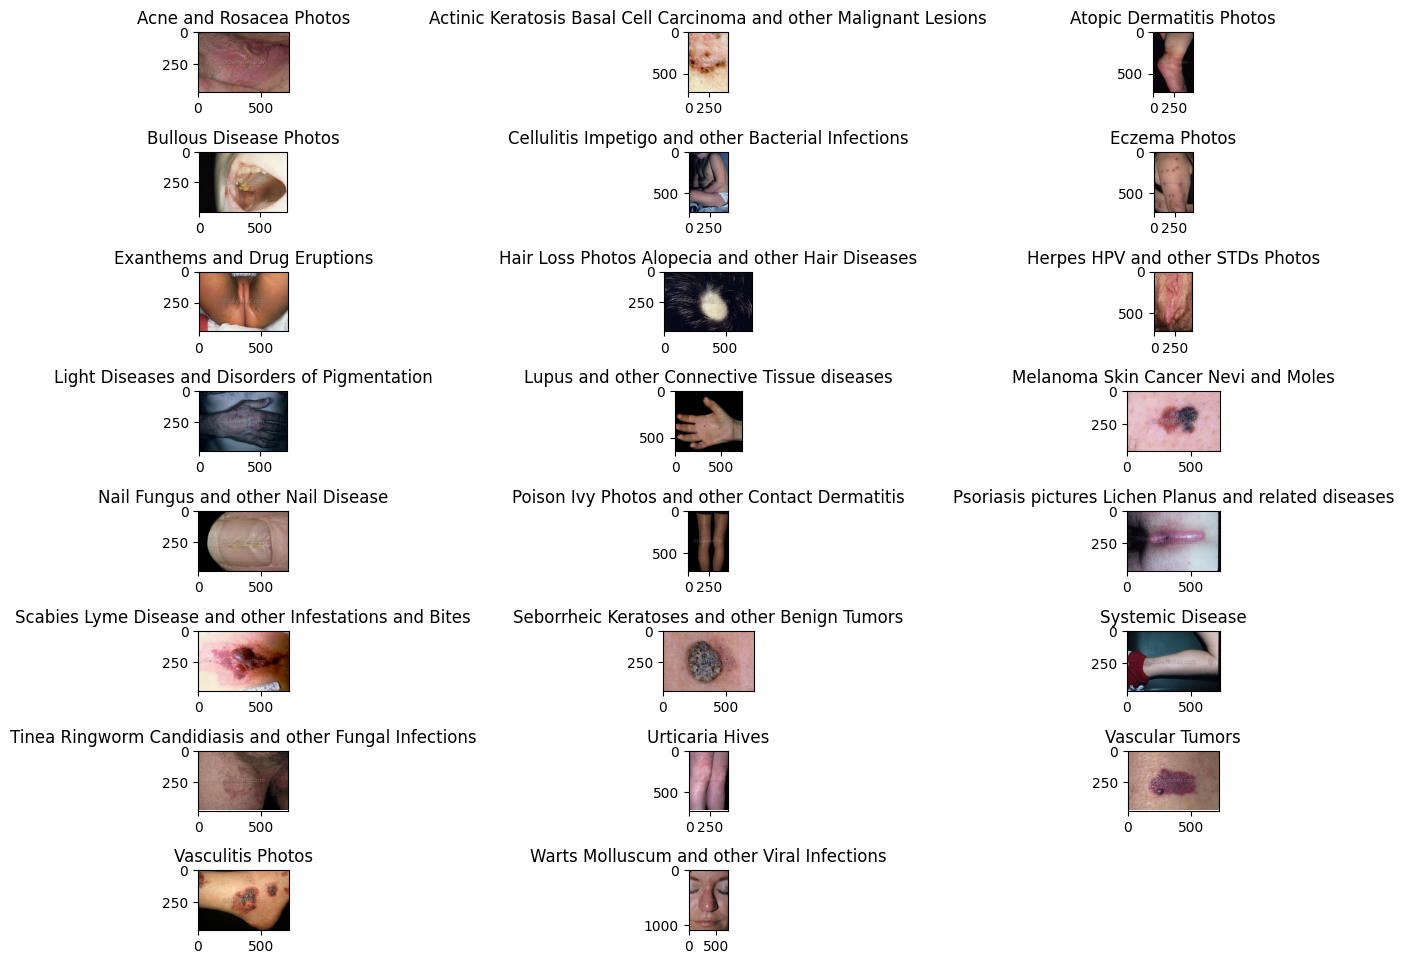

In [14]:
# Set up the folder where the images are
src_folder = 'dermnet/train'

# Set up a figure of an appropriate size
fig = plt.figure(figsize=(15, 35))

# loop through the subfolders
for root, folders, filenames in os.walk(src_folder):
    image_num = 0
    num_folders = len(folders)
    for folder in sorted(folders):
        # Keep an incrementing count of each image
        image_num +=1
        # Find the image file in the folder
        file_name = os.listdir(os.path.join(root,folder))[8]
        # Get the full path from the root folder
        file_path = os.path.join(root,folder, file_name)
        # Open the file using the matplotlib.image library
        image = mp_image.imread(file_path)
        # Add the image to the figure (which will have a row for each folder, each containing 3 column for the image)
        a = fig.add_subplot(num_folders, 3, image_num)
        # Add the image to the plot
        image_plot = plt.imshow(image)
        # Add a caption with the folder name
        a.set_title(folder)

# Adjust vertical space
fig.subplots_adjust(hspace=1, wspace=1)

# Show the plot
plt.show()

In [15]:
# Number of classes in the dataset
num_classes = 23

# Batch size for training (change depending on how much memory you have)
batch_size = 32

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True
input_size = 224

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
                #update_bn_stats(model=model, data_loader=dataloaders[phase])  # if update_bn_stats

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                      # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

               # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [17]:
def test_model(model, dl, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  total = 0
  num_correct = 0
  with torch.no_grad():
      for images, labels in dl:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())
          total += labels.size(0)
          num_correct += (predicted == labels).sum()
      print(f"Test Accuracy of the model: {float(num_correct)/float(total)*100:.2f}")
      true_labels = np.hstack(true_labels)
      predictions = np.hstack(predictions)

  return true_labels, predictions

In [18]:
# x, y - find the img from class x labelled as class y
def test(model, dl, x, y, normalize=True):
  model.eval()
  true_labels = []
  predictions = []
  images_list = []

  with torch.no_grad():
      for images, labels in dl:
          images_list.append(images.cpu().numpy())
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          predicted = torch.argmax(outputs.data,-1)
          true_labels.append(labels.cpu().numpy())
          predictions.append(predicted.cpu().numpy())

  for n in range(60):
    for i in range(32):
      if (true_labels[n][i] == x)  & (predictions[n][i] == y):
        #inv_tensor = inv_normalize(image_list[n][i]])
        plt.imshow(np.transpose(images_list[n][i], (1, 2, 0)))
        plt.show()

In [21]:
# Number of epochs to train for
num_epochs = 50

model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, 23, bias=True)

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

In [22]:
# Train and evaluate
model, hist = train_model(model, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 2.1915 Acc: 0.3532
val Loss: 1.8763 Acc: 0.4473

Epoch 1/49
----------
train Loss: 1.7065 Acc: 0.4875
val Loss: 1.6489 Acc: 0.5037

Epoch 2/49
----------
train Loss: 1.4045 Acc: 0.5727
val Loss: 1.5862 Acc: 0.5282

Epoch 3/49
----------
train Loss: 1.1630 Acc: 0.6442
val Loss: 1.5431 Acc: 0.5672

Epoch 4/49
----------
train Loss: 0.9163 Acc: 0.7162
val Loss: 1.5742 Acc: 0.5602

Epoch 5/49
----------
train Loss: 0.7598 Acc: 0.7595
val Loss: 1.5994 Acc: 0.5632

Epoch 6/49
----------
train Loss: 0.6230 Acc: 0.8041
val Loss: 1.5961 Acc: 0.5902

Epoch 7/49
----------
train Loss: 0.5300 Acc: 0.8304
val Loss: 1.5774 Acc: 0.6002

Epoch 8/49
----------
train Loss: 0.4469 Acc: 0.8526
val Loss: 1.5802 Acc: 0.6157

Epoch 9/49
----------
train Loss: 0.3770 Acc: 0.8773
val Loss: 1.6292 Acc: 0.6177

Epoch 10/49
----------
train Loss: 0.3568 Acc: 0.8814
val Loss: 1.6839 Acc: 0.6052

Epoch 11/49
----------
train Loss: 0.3203 Acc: 0.8916
val Loss: 1.7993 Acc: 0.6012

Ep

In [28]:
from google.colab import drive
drive.mount('/content/drive')   # Sol tarafta yetki isteyecek


Mounted at /content/drive


In [29]:
import os, torch

# 🔸 Modeli kaydetmek istediğiniz tam yol (.pth dahil)
drive_path = '/content/drive/MyDrive/dermnet_classification/ResNet50_dermnet23.pth'

# Klasör yoksa oluştur
os.makedirs(os.path.dirname(drive_path), exist_ok=True)

# model: eğittiğiniz PyTorch modeli
torch.save(model.state_dict(), drive_path)
print(f"Model kaydedildi ➜ {drive_path}")


Model kaydedildi ➜ /content/drive/MyDrive/dermnet_classification/ResNet50_dermnet23.pth


In [23]:
torch.save(model.state_dict(), 'Resnet50pretrained_50epoch_v3_8')

In [24]:
model.load_state_dict(torch.load('Resnet50pretrained_50epoch_v3_8'))

<All keys matched successfully>

Test Accuracy of the model: 62.57


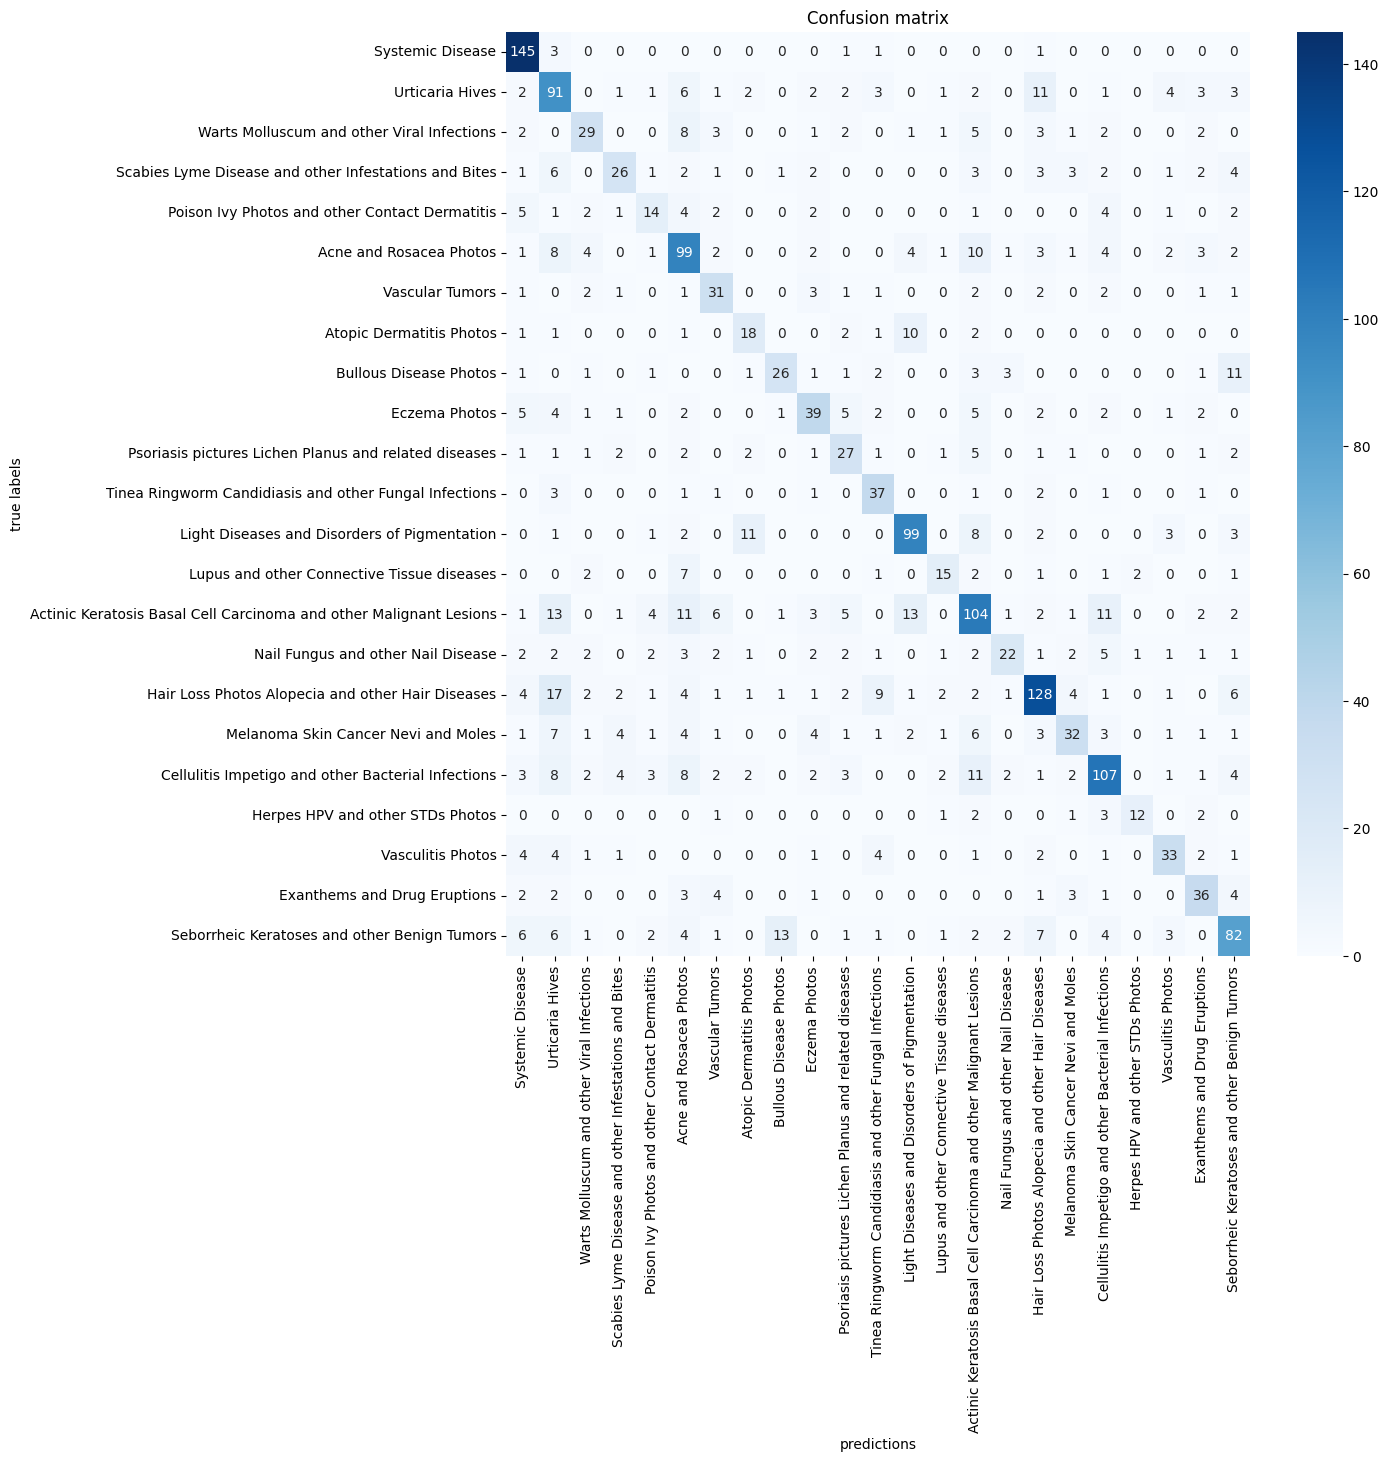

In [25]:
true_labels, predictions = test_model(model, dataloader_test, normalize=True)
c_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(12, 12))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=True)
plt.xlabel('predictions')
plt.ylabel('true labels')
plt.show()

In [26]:
# False pediction
test(model, dataloader_test, 5, 14)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
# Correct pediction of 'Eczema Photos'
test(model, dataloader_test, 5, 5)

Output hidden; open in https://colab.research.google.com to view.

In [39]:

import torch, glob, random
from torchvision import models, transforms, datasets
from PIL import Image
import matplotlib.pyplot as plt

ckpt_path = '/content/drive/MyDrive/dermnet_classification/ResNet50_dermnet23.pth'  # <- değiştirin

test_dir  = '/content/dermnet/test'                              # <- değiştirin

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 1️⃣ ResNet-50 mimarisi (23 sınıf) oluştur
model = models.resnet50(pretrained=False)
model.fc = torch.nn.Linear(model.fc.in_features, 23)

# 2️⃣ Ağırlıkları yükle
state = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state)
model.to(device).eval()

# 3️⃣ ImageFolder ile sınıf adı ↔ indis eşlemesi
test_dataset = datasets.ImageFolder(test_dir)   # sadece metadata için
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}

# 4️⃣ Inference dönüşümü (eğitimde kullandığınızla aynı olmalı!)
infer_tf = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std =[0.229,0.224,0.225]),
])



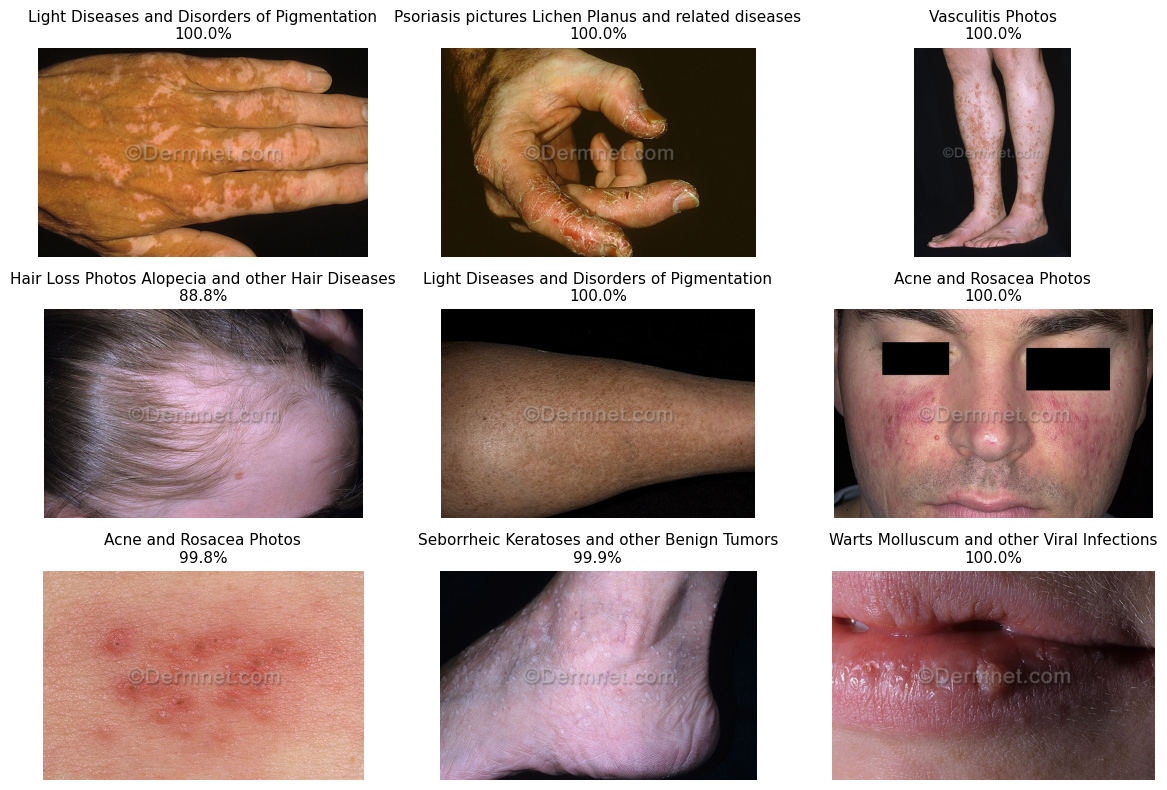

In [38]:

img_paths = glob.glob(test_dir + '/**/*.jpg', recursive=True) + \
            glob.glob(test_dir + '/**/*.png', recursive=True)

assert len(img_paths) >= 9, "Test klasöründe yeterli görsel yok!"

sample_imgs = random.sample(img_paths, 9)

# 2️⃣ Her görüntü için tahmin
plt.figure(figsize=(12, 8))
for i, path in enumerate(sample_imgs, 1):
    img = Image.open(path).convert('RGB')
    inp = infer_tf(img).unsqueeze(0).to(device)

    with torch.no_grad():
        logits = model(inp)
        prob   = torch.softmax(logits, dim=1)
        cls_id = prob.argmax(1).item()
        cls_nm = idx_to_class[cls_id]
        conf   = prob[0, cls_id].item()

    # 3️⃣ Göster
    plt.subplot(3, 3, i)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f'{cls_nm}\n{conf:.1%}', fontsize=11)

plt.tight_layout()
plt.show()
